## Author:  Areg Danagoulian (aregjan@mit.edu), with initial code from Nolan Kowitt

**License: see LICENSE**

The code below connects to a Siglent scope, and reads data from it. It has been tested with SIGLENT SDS 1202X-E.

In all examples below we use Channel1 of the scope -- C1 for short. You can always change it to C2.

* Documentation: https://siglentna.com/wp-content/uploads/dlm_uploads/2017/10/ProgrammingGuide_forSDS-1-1.pdf

Requirements:

* pip install pyvisa
* pip install pyvisa-py
* pip install zeroconf #slow!
* pip install typing-extensions --upgrade
* go to https://www.ni.com/en/support/downloads/drivers/download/unpackaged.ni-visa.487529.html and install the drivers

In [1]:
import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt
import struct
import re
#from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

In [2]:
def get_scope_settings(scope):
    div=float(scope.query('C1:VDIV?')[8:16]) #volts per division -- this is not safe, regexp would be better
    ofst=float(scope.query('C1:OFST?')[8:16]) #offset in volts

    trdl_query=scope.query('TRDL?') #centering of the horizontal axis, time
    trdl=float(re.search(r"TRDL(.*)S", trdl_query).group(1)) #first do a regex, then pick the first match. Convert to float

    #print(scope.query('TDIV?')) #times per division
    tdiv_query=scope.query('TDIV?') #times per division
    tdiv=float(re.search(r"TDIV(.*)S", tdiv_query).group(1)) #first do a regex, then pick the first match. Convert to float


    #print(scope.query('SARA?')) #sampling rate
    sara_query=scope.query('SARA?') #sampling rate
    sara=float(re.search(r"SARA(.*)S", sara_query).group(1)) #first do a regex, then pick the first match. Convert to float
    return div,ofst,trdl,tdiv,sara

In [20]:
def acquire_data(scope,time_measurement,baseline_length, positive_polarity): #need the scope handler, time (in sec), as well as the polarity of the expected pulse
#Here we take the pulses and integrate them (for many detectors the integral of the pulse is proportional to the deposited energy)
#.   scope:  the handler for the scope object
#.   time_measurement:  the measurement time, in SECONDS
#    baseline_length:  the length of baseline, in seconds.  It's computed from the beginning of the waveform
#    positive_polarity:  logical. Is your sensor outputing positive pulse?  Then YES.  If it's negative then NO.

    print("Acquiring data for %d seconds." % time_measurement)
    t_start = time.time() #time start
    data=np.empty(0) #this is the array that we will fill
    #VM = float(re.search(r"C1:PAVA? AMPL,(.*)V", scope.query('C1:PAVA? AMPL')).group(1))
    #print(VM)
    scope.baud_rate = 115200
    div,ofst,trdl,tdiv,sara = get_scope_settings(scope)
    cymo_total=0
    VM=0
    while(time.time()-t_start<=time_measurement): #the main loop
        scope.write('C1:WF? DAT2') #three options:  DAT2(just data); DESC(descriptor); ALL
        raw_data =scope.read_raw()
        samples=int(raw_data[13:22].decode("utf-8")) #this provides the descriptor, with the number of samples at the end
        integer_array = np.array([int(byte) for byte in raw_data[22:22+samples]])
        #now clean up the problem of >127, as the range in y starts from 0, and goes to the top of the screen(127)
        #then cycles from the bottom of the screen to the origin
        integer_array[integer_array>127]=integer_array[integer_array>127]-255
        v = (integer_array * div/25) - ofst #claculate the actual voltages
        time_s=np.arange(samples)
        time_s=trdl-(7.0*tdiv)+time_s/sara 

        v_baseline = np.sum(v[time_s<trdl-(7.*tdiv)+baseline_length])/len(v[time_s<trdl-(7.*tdiv)+baseline_length])

        if(positive_polarity): #positive pulse
            v_sum=np.sum(v-v_baseline)
        else:
            v_sum=np.sum(v_baseline-v)

        if(v_sum!=VM):
            data=np.append(data,v_sum)
            VM=v_sum

#Now let's try to determine the dead time
        if((time.time()-t_start)%2<=0.05): #every two seconds read the cymometer.  This is probably wrong!!
            cymo_query=scope.query('CYMOMETER?') #sampling rate
#            print(cymo_query)
            cymo=float(re.search(r"CYMT (.*)Hz", cymo_query).group(1)) #first do a regex, then pick the first match. Convert to float
            cymo_total+=cymo*2
    print("Acquired %d waveforms\n" % data.size)
    print("Total triggers: %d" % cymo_total)
    live_time = float(time_measurement)*float(data.size)/float(cymo_total)
    live_time
    data.size
    cymo_total
    time_measurement
    print("Effective live time: %f seconds" % live_time)
    return data

### Let's start by checking for resources.  List 'em. 

In [12]:
rm = pyvisa.ResourceManager()
rm.list_resources() #this will show a number of devices, which will hopefully include something like the next line

('ASRL1::INSTR', 'ASRL2::INSTR', 'USB0::0xF4ED::0xEE3A::SDS1EEFD7R4087::INSTR')

In [13]:
#scope = rm.open_resource('USB0::0x1AB1::0x0588::DS1ET171304397::INSTR') # you typically get an identifyer like this
if(len(rm.list_resources())==3):
    scope = rm.open_resource(rm.list_resources()[2]) #update the identifier
    if(scope.open):
        print(scope.query("*IDN?")) #should return the brand and model
    else:
        print("No connection to a scope.")
else:
    print("Couldn't identify a scope. Check for connection, and then go to the above cell.")
    


Siglent Technologies,SDS1202X-E,SDS1EEFD7R4087,1.3.27



### Let's first get some interesting parameters


In [14]:
print(scope.query('C1:PAVA? PKPK')) #peak to peak
print(scope.query('C1:PAVA? MAX')) #max
print(scope.query('C1:PAVA? MIN')) #min
print(scope.query('C1:PAVA? AMPL'))#negative overshoot
#print(scope.query('c1:PAVA? ALL')) #EVERYTHING
print(scope.query('CYMOMETER?')) # this is VERY useful -- will allow calculation of dead times
print(scope.query('TRDL?')) #centering of the horizontal axis, time
print(scope.query('TDIV?')) #times per division
print(scope.query('SARA?')) #sampling rate


C1:PAVA PKPK,6.320000E+00V

C1:PAVA MAX,4.640000E+00V

C1:PAVA MIN,-1.680000E+00V

C1:PAVA AMPL,4.480000E+00V

CYMT 1.01E+01Hz

TRDL -0.00E+00S

TDIV 1.00E-07S

SARA 1.00E+09Sa/s



For documentation on waveform transfer, see p. 141 in 
https://siglentna.com/wp-content/uploads/dlm_uploads/2017/10/ProgrammingGuide_forSDS-1-1.pdf

### Now let's transfer and plot actual waveforms!

9.436249732971192e-05


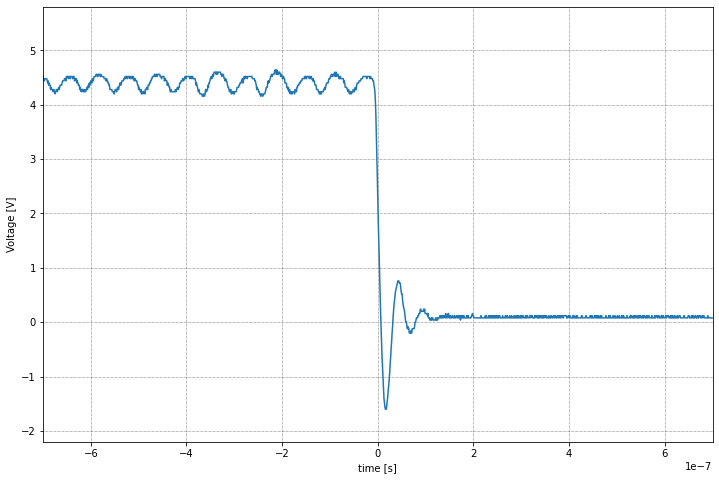

In [18]:
verbose=False

div,ofst,trdl,tdiv,sara = get_scope_settings(scope)
if verbose:
    print(ofst)
    print(trdl)
    print(tdiv)
    print(sara)

scope.baud_rate = 115200
time0=time.time()
for i in range(1):
    scope.write('C1:WF? DAT2') #three options:  DAT2(just data); DESC(descriptor); ALL
    raw_data =scope.read_raw()
print((time.time()-time0)/400.)




samples=int(raw_data[13:22].decode("utf-8")) #this provides the descriptor, with the number of samples at the end
integer_array = np.array([int(byte) for byte in raw_data[22:22+samples]])
#now clean up the problem of >127, as the range in y starts from 0, and goes to the top of the screen(127)
#then cycles from the bottom of the screen to the origin
integer_array[integer_array>127]=integer_array[integer_array>127]-255

v = (integer_array * div/25) - ofst #claculate the actual voltages


#now make an array of samples' time
time_s=np.arange(samples)
time_s=trdl-(7.0*tdiv)+time_s/sara 

if verbose:
    print(samples)
    print(integer_array)
    print(v)
    print(time_s)

fig, ax = plt.subplots(figsize=(12, 8))  
ax.plot(time_s,v)
ax.set_xlabel('time [s]')
ax.set_ylabel('Voltage [V]')
ax.set_ylim(-4*div-ofst,4*div-ofst)
ax.set_xlim(-7*tdiv+trdl,7*tdiv+trdl)
ax.grid(True,which='major', linestyle=':', linewidth='0.5', color='black')

Acquiring data for 5 seconds.
Acquired 41 waveforms

Total triggers: 85
Effective live time: 2.406103 seconds


Text(0.5, 0, 'Integral [V*samples]')

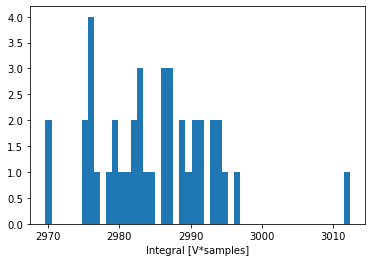

In [21]:
data=acquire_data(scope,5,50e-9,False) #first argument is the scope handler. Next is time.  False denotes negative polarity.  The third argument denotes the time in s for the baseline estimation
h = plt.hist(data,bins=50) #let's histogram data
plt.xlabel("Integral [V*samples]")

## You can ignore the rest.  It's code for histogramming and fitting spectral data from a NaI detector

In [111]:
def gaussian_plusline(x,mu,sig,A,alpha,beta):
    return alpha+x*beta+A*np.exp(-(x-mu)**2/2/sig**2)
def gaussian(x,mu,sig,A):
    return A*np.exp(-(x-mu)**2/2/sig**2)

0.0056714291298985 0.006776254649038748
3.9133824537287 78.66138096948848


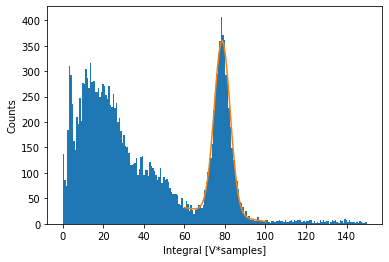

In [115]:
ys,xs = np.histogram(data,bins=200,range=(0,150))

xs = xs[1:]-xs[1]/2

mask = np.logical_and(xs>60, xs<100)

par,cov = curve_fit(gaussian_plusline,xs[mask],ys[mask],sigma=np.sqrt(ys[mask]+1),p0 = [80,3,50,0,0])
h = plt.hist(data,bins=200,range=(0,150)) #let's histogram data

xstoplt = np.linspace(60,100)
ystoplt = gaussian_plusline(xstoplt,*par)

plt.plot(xstoplt,ystoplt)
plt.xlabel("Integral [V*samples]")
plt.ylabel("Counts")
plt.savefig('my_plot.png') 

print(cov[1,1],cov[0,0])
print(par[1],par[0])

0.03554894294822303 0.08280285242696021
4.76898426939132 78.01363914634011


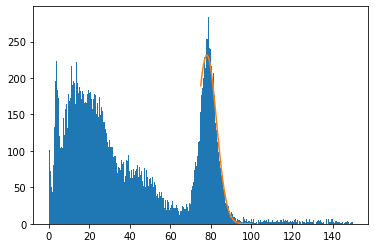

In [113]:
#same as above, but just a gaussian fit
ys,xs = np.histogram(data,bins=300,range=(0,150))

xs = xs[1:]-xs[1]/2

mask = np.logical_and(xs>75, xs<100)

par,cov = curve_fit(gaussian,xs[mask],ys[mask],sigma=np.sqrt(ys[mask]+1),p0 = [80,5,400])
h = plt.hist(data,bins=300,range=(0,150)) #let's histogram data

xstoplt = np.linspace(75,100)
ystoplt = gaussian(xstoplt,*par)

plt.plot(xstoplt,ystoplt)


print(cov[1,1],cov[0,0])
print(par[1],par[0])